In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm, bernoulli, multinomial, gaussian_kde, shapiro, kstest, poisson
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn import metrics
import scipy.stats
from sklearn.metrics import classification_report

In [2]:
# intente con la multinomial (mala idea)
def probability_categorical(attribute, value, Iwi):
    exitoIwi = len(Iwi[Iwi[attribute] == value])
    nIwi = len(Iwi)
    p = exitoIwi/nIwi
    return p

In [3]:
def fit(predictoras, apredecir, dictionary_of_distributions, esnormal):
    
    # confirmation message
    if esnormal: print('Fitting con normal')
    else: print('Fitting con kde')
    
    # lo estaba haciendo con df :p
    df = pd.concat([predictoras, apredecir], axis=1)

    # para que los wi[i] esten boniton (wi[3] sean los de la clase 3)
    df = df.sort_values(by=apredecir.name)
    
    classes = apredecir.unique()        # M
    total = len(df)                     # total
    attributes = predictoras.columns    # X_i i \in {1, 2, ...}

    Iwi = []        # Iwi (given wi)
    pwi = []        # a priori probability
    pxjIwi = []     # p(X_j|w_i) 

    newdistributions = {}   # diccionario con las distribuciones que se van a usar

    for i in range(len(classes)):                   # For every class

        # Las probabilidades a priori de cada clase en Y. Es decir, P(Y=y_i)

        Iwi.append(df[df[apredecir.name] == classes[i]])    # un dataframe con las X que son de la clase i
        pwi.append(len(Iwi[i])/total)                       # Append the a priori probability
        pxjIwi.append([])                                   # las distribuciones condicionales de cada atributo 

        # creamos un diccionario con las distribuciones de cada atributo para la clase i
        newdistributions[classes[i]] = {}                   # las distribuciones de cada atributo


        # Las funciones de masa o densidad de probabilidad condicionales

        for attribute in attributes:

            if dictionary_of_distributions[attribute] == 'categorica':

                if len(Iwi[i][attribute].unique()) == 2:
                    newdistributions[classes[i]][attribute] = 'bernoulli'   # al final ya no se usa el diccionario, pero queda bonito
                    teta = Iwi[i][attribute].mean()
                    un_pxiIwi = bernoulli(teta)             
                    pxjIwi[i].append(un_pxiIwi)                             # guardamos la distribucion condicional bernoulli
                    
                else: 
                    newdistributions[classes[i]][attribute] = 'multinomial' # avisamos que es multinomial
                    # multinomial (1, p) es la distribucion de probabilidad de un vector de 1 elemento con probabilidad p
                    un_pxiIwi = multinomial(1, Iwi[i][attribute].value_counts(normalize=True))  # vivi una falacia del concorde, pero no sabia como asignarle una distribucion a cada valor
                    pxjIwi[i].append(un_pxiIwi)
                    
                    

            elif dictionary_of_distributions[attribute] == 'entera':
                newdistributions[classes[i]][attribute] = 'poisson'         # avisamos que es poisson
                lambda_ = Iwi[i][attribute].mean()
                un_pxiIwi = poisson(lambda_)
                pxjIwi[i].append(un_pxiIwi)                                 # guardamos la distribucion condicional poisson   


            elif dictionary_of_distributions[attribute] == 'continua':
                # depende que se pidio
                if esnormal:
                    newdistributions[classes[i]][attribute] = 'normal'
                    xbar = Iwi[i][attribute].mean()
                    s = Iwi[i][attribute].std()
                    un_pxiIwi = norm(xbar, s)
                    pxjIwi[i].append(un_pxiIwi)
                    
                else:
                    newdistributions[classes[i]][attribute] = 'kde'
                    un_pxiIwi = gaussian_kde(Iwi[i][attribute])
                    pxjIwi[i].append(un_pxiIwi)
                    


    return pxjIwi, pwi, Iwi, classes, attributes, newdistributions

In [4]:
# la usamos para la multinomial
def numtoarray(num, size):
    # no acepta floats
    num = int(num)
    array = [0] * size
    array[num] = 1  # ponemos un 1 en la posicion del num
    return array

In [5]:
def predict(pxjIwi, pwi, Iwi, classes, attributes, newdistributions, age, sex, chest_pain_type, resting_blood_pressure, cholesterol, fasting_blood_sugar, resting_ecg, max_heart_rate, exercise_induced_angina, st_depression, slope, number_of_major_vessels, thal):

    # P(w_i|x) = P(w_i) * \Pi p(X|w_i)
    Pwis = []
    
    # its easier 
    attributes_values = [age, sex, chest_pain_type, resting_blood_pressure, cholesterol, fasting_blood_sugar, resting_ecg, max_heart_rate, exercise_induced_angina, st_depression, slope, number_of_major_vessels, thal]


    for i in range(len(classes)):

        # It depends on the distribution

        # a priori probability
        Pwi = pwi[i]
        for attribute in range(len(attributes_values)):
            
            # el diccionario puede entrar a i porque es un num, attributes[attribute] es el nombre del atributo (attributes[0] = 'Age')
            # newdistributions[1]['Age'] == 'kde' o 'normal' 

            # if its poisson
            if type(pxjIwi[i][attribute]) == scipy.stats._discrete_distns.bernoulli_gen:
                # pxjIwi[i][attribute] es donde esta una distribucion
                evaluation = pxjIwi[i][attribute].pmf(attributes_values[attribute])
                Pwi *= evaluation

            # if its normal
            elif type(pxjIwi[i][attribute]) == scipy.stats._continuous_distns.norm_gen:
                evaluation = pxjIwi[i][attribute].pdf(attributes_values[attribute])
                Pwi *= evaluation

            # if its kde
            elif type(pxjIwi[i][attribute]) == scipy.stats._kde.gaussian_kde:
                evaluation = pxjIwi[i][attribute].pdf(attributes_values[attribute])
                Pwi *= evaluation

            # if its bernoulli
            elif type(pxjIwi[i][attribute]) == scipy.stats._distn_infrastructure.rv_discrete_frozen:
                evaluation = pxjIwi[i][attribute].pmf(attributes_values[attribute])
                Pwi *= evaluation

            # if its multinomial
            elif type(pxjIwi[i][attribute]) == scipy.stats._multivariate.multinomial_frozen:

                name_of_attribute = attributes[attribute]
                
                # the size of the array depends on the Iw_i    
                num = attributes_values[attribute]
                size = len(pxjIwi[i][attribute].p)

                # unique values of the attribute
                unique_values = Iwi[i][name_of_attribute].unique()
                unique_values = unique_values.tolist()
                unique_values.sort()

                # replace the float for ints
                unique_values = [int(i) for i in unique_values]

                # get the index of the value
                if num in unique_values:
                    num = unique_values.index(num)

                    # get the array because multinomial needs an array
                    arrvalue = numtoarray(num, size)

                    evaluation = pxjIwi[i][attribute].pmf(arrvalue)
                    Pwi *= evaluation

                else:
                    # if the value is not in the unique values, then we return 0
                    # (sometimes it can happen)
                    evaluation = 0
                    Pwi *= evaluation


        # list of P(w_i|X)
        Pwis.append(Pwi)

    # because of the multlinamial, pwis is a list of nparrays
    values_pwis = np.array(Pwis)
    argmax = np.nanargmax(values_pwis)  # it must be nanargmax because it can have nan values (i suffured because of this)
    
    return argmax

In [6]:
def probar_el_clasificador(predictoras, apredecir, classes, Iwi, distributions, esnormal, pxjIwi, pwi, attributes):

    # Shuffle the rows
    for clase in range(len(classes)):
        # sample(frac=1) shuffles the rows of the dataframe and reset_index(drop=True) resets the index
        Iwi[clase] = Iwi[clase].sample(frac=1).reset_index(drop=True)   


    # Esto era le que estaba pensando de hacer muchos train y test y el promedio de los resultados

    # Es un minitrain porque se divide por los Iwis ↓↓
    minitrain = []
    minitest = []

    # Se hace asi para tener al menos un wi de cada clase
    for clase in range(len(classes)): 
        minitrain.append(Iwi[clase].iloc[:  int(len(Iwi[clase])*0.8), :])   # 80% of the rows
        minitest.append(Iwi[clase].iloc[int(len(Iwi[clase])*0.8):, :])      # 20% of the rows

    # Un traindf ya es un train bien hecho con todas las clases (del 80%)
    traindf = pd.concat(minitrain, ignore_index=True)
    testdf = pd.concat(minitest, ignore_index=True)

    # Vamos a .fit el traindf
    predictoras_train = traindf[predictoras.columns]    # No es un iloc porque la que queremos predecir puede no ser la ultima
    apredecir_train = traindf[apredecir.name]

    # Fitteamos ajajja el modelo con el traindf

    # fit(predictoras, apredecir, dictionary_of_distributions, esnormal=False):
    # return pxjIwi, pwi, Iwi, classes, attributes, newdistributions
    pxjIwi, pwi, Iwi, classes, attributes, newdistributions = fit(predictoras_train, apredecir_train, distributions, esnormal)

    # Vector de predicciones
    predictions = []
    
    # Vamos a .predict el testdf
    for i in range(len(testdf)):    # con todos los datos del testdf

        # lo siento se ve feo
        agetest = testdf.iloc[i, 0]
        sextest = testdf.iloc[i, 1]
        chest_pain_typetest = testdf.iloc[i, 2]
        resting_blood_pressuretest = testdf.iloc[i, 3]
        cholesteroltest = testdf.iloc[i, 4]
        fasting_blood_sugartest = testdf.iloc[i, 5]
        resting_ecgtest = testdf.iloc[i, 6]
        max_heart_ratetest = testdf.iloc[i, 7]
        exercise_induced_anginatest = testdf.iloc[i, 8]
        st_depressiontest = testdf.iloc[i, 9]
        slopetest = testdf.iloc[i, 10]
        number_of_major_vesselstest = testdf.iloc[i, 11]
        thaltest = testdf.iloc[i, 12]

        # def predict(pxjIwi, pwi, Iwi, classes, attributes, newdistributions, age, sex, chest_pain_type, resting_blood_pressure, cholesterol, fasting_blood_sugar, resting_ecg, max_heart_rate, exercise_induced_angina, st_depression, slope, number_of_major_vessels, thal):
            # return argmax
        predictpredict = predict(pxjIwi, pwi, Iwi, classes, attributes, distributions, agetest, sextest, chest_pain_typetest, resting_blood_pressuretest, cholesteroltest, fasting_blood_sugartest, resting_ecgtest, max_heart_ratetest, exercise_induced_anginatest, st_depressiontest, slopetest, number_of_major_vesselstest, thaltest)
        predictions.append(predictpredict)
        
    # add the predictions to the dataframe
    testdf["PREDICT PREDICT"] = predictions

    return testdf

In [7]:
def matriz_confusion(y_true, y_pred, cmap='Blues', title='Matriz de Confusión', xlabel='Predicciones', ylabel='Verdaderos'):

    cm = confusion_matrix(y_true, y_pred)

    fig, ax = plt.subplots(figsize=(4, 4), dpi=150)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=cmap, ax=ax, colorbar=False)
    # 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Grays', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_grey', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gist_yerg', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'grey', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'
    
    ax.set_title(f'{title}\n', fontsize=10, fontweight='bold')
    ax.set_xlabel(xlabel, fontsize=8)
    ax.set_ylabel(ylabel, fontsize=8)
    
    plt.show()

In [8]:
class bayes_naive:
    # solo ponemos lo que teniamos en las funciones, es mas facil de leer asi, el trabajo de antes estaba feito
    def __init__(self, normalokde):

        if normalokde == 'normal' or normalokde == 'Normal':
            self.esnormal = True
            print('Se usara la distribucion normal')
        else:
            self.esnormal = False
            print('Se usara la distribucion kde')

    # fit(predictoras, apredecir, dictionary_of_distributions, esnormal=False):
        # return pxjIwi, pwi, Iwi, classes, attributes, newdistributions
    def fit(self, predictoras, apredecir, dictionary_of_distributions):
        self.pxjIwi, self.pwi, self.Iwi, self.classes, self.attributes, self.newdistributions = fit(predictoras, apredecir, dictionary_of_distributions, self.esnormal)

        self.predictoras = predictoras
        self.apredecir = apredecir
        self.dictionary_of_distributions = dictionary_of_distributions
        
        return self.pxjIwi, self.pwi, self.Iwi, self.classes, self.attributes, self.newdistributions

    # def predict(pxjIwi, pwi, Iwi, classes, attributes, newdistributions, age, sex, chest_pain_type, resting_blood_pressure, cholesterol, fasting_blood_sugar, resting_ecg, max_heart_rate, exercise_induced_angina, st_depression, slope, number_of_major_vessels, thal):
        # argmax
    def predict(self, age, sex, chest_pain_type, resting_blood_pressure, cholesterol, fasting_blood_sugar, resting_ecg, max_heart_rate, exercise_induced_angina, st_depression, slope, number_of_major_vessels, thal):
        return predict(self.pxjIwi, self.pwi, self.Iwi, self.classes, self.attributes, self.newdistributions, age, sex, chest_pain_type, resting_blood_pressure, cholesterol, fasting_blood_sugar, resting_ecg, max_heart_rate, exercise_induced_angina, st_depression, slope, number_of_major_vessels, thal)
    
    # probar_el_clasificador(predictoras, apredecir, classes, Iwi, distributions, esnormal, pxjIwi, pwi, attributes)
        # return testdf
    def probar_el_clasificador(self):
        testdf = probar_el_clasificador(self.predictoras, self.apredecir, self.classes, self.Iwi, self.dictionary_of_distributions, self.esnormal, self.pxjIwi, self.pwi, self.attributes)
        self.testdf = testdf
        return testdf
    
    def confusion_matrix(self, cmap='Blues', xlabel='Predicciones', ylabel='Verdaderos'):
        """
        ¡Le puedes poner color! 
        """

        if self.esnormal: title = 'Matriz de Confusión con distribución Normal'
        else: title = 'Matriz de Confusión con distribución KDE'

        self.y_pred = self.testdf['PREDICT PREDICT']
        self.y_true = self.testdf[self.apredecir.name]
        return matriz_confusion(self.y_true, self.y_pred, cmap, title, xlabel, ylabel)
    
    def reporte_de_clasificacion(self):
        return print(classification_report(self.y_true, self.y_pred, zero_division=0))



# **Ejemplo**

In [9]:
cleavland = pd.read_csv('05-heart+disease/processed.cleveland.data', header=None, encoding='ISO-8859-1')
hungary = pd.read_csv('05-heart+disease/processed.hungarian.data', header=None, encoding='ISO-8859-1')
switzerland = pd.read_csv('05-heart+disease/processed.switzerland.data', header=None, encoding='ISO-8859-1')
va = pd.read_csv('05-heart+disease/processed.va.data', header=None, encoding='ISO-8859-1')

In [10]:
attributes = ["Age", "Sex", "Chest Pain Type", "Resting Blood Pressure", "Cholesterol", "Fasting Blood Sugar", "Resting ECG", "Max Heart Rate", "Exercise Induced Angina", "ST Depression", "Slope", "Number of Major Vessels", "Thal", "Diagnosis of Heart Disease"]

In [11]:
cleavland.columns = attributes
hungary.columns = attributes
switzerland.columns = attributes
va.columns = attributes

In [12]:
df = pd.concat([cleavland, hungary, switzerland, va], ignore_index=True)

In [13]:
# # it got really really bad
# from sklearn.impute import KNNImputer

# # Replace "?" with NaN
# df.replace("?", np.nan, inplace=True)

# # if the last colum is nan drop the row
# df = df.dropna(subset=[df.columns[-1]])

# # Convert all columns to numeric
# df = df.apply(pd.to_numeric)

# # Initialize KNNImputer
# imputer = KNNImputer(n_neighbors=2)

# # Fit and transform the data
# df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# # make all values integers
# df_imputed = df_imputed.astype(int)

# df = df_imputed

In [14]:
df.replace("?", np.nan, inplace=True)
df.dropna(inplace=True)
df = df.apply(pd.to_numeric)

In [15]:
distributions = {
    'Age': 'continua',
    'Sex': 'categorica',
    'Chest Pain Type': 'entera', 
    'Resting Blood Pressure': 'continua',
    'Cholesterol': 'continua',
    'Fasting Blood Sugar': 'categorica', 
    'Resting ECG': 'categorica',
    'Max Heart Rate': 'continua',
    'Exercise Induced Angina': 'categorica',
    'ST Depression': 'continua',
    'Slope': 'categorica',
    'Number of Major Vessels': 'categorica', 
    'Thal': 'categorica', 
    'Diagnosis of Heart Disease': 'categorica'
}

In [16]:
predictoras = df.iloc[:, :-1]
apredecir = df.iloc[:, -1]

## **Ejemplo KDE**

In [17]:
bn = bayes_naive('kde')

Se usara la distribucion kde


In [18]:
pxjIwi, pwi, Iwi, classes, attributes, newdistributions = bn.fit(predictoras, apredecir, distributions)

Fitting con kde


In [19]:
age = 63
sex = 1
chest_pain_type = 3
resting_blood_pressure = 145
cholesterol = 233
fasting_blood_sugar = 1
resting_ecg = 0
max_heart_rate = 150
exercise_induced_angina = 0
st_depression = 2.3
slope = 1
number_of_major_vessels = 0
thal = 3

In [20]:
bn.predict(age, sex, chest_pain_type, resting_blood_pressure, cholesterol, fasting_blood_sugar, resting_ecg, max_heart_rate, exercise_induced_angina, st_depression, slope, number_of_major_vessels, thal) 

0

In [21]:
testdf = bn.probar_el_clasificador()

Fitting con kde


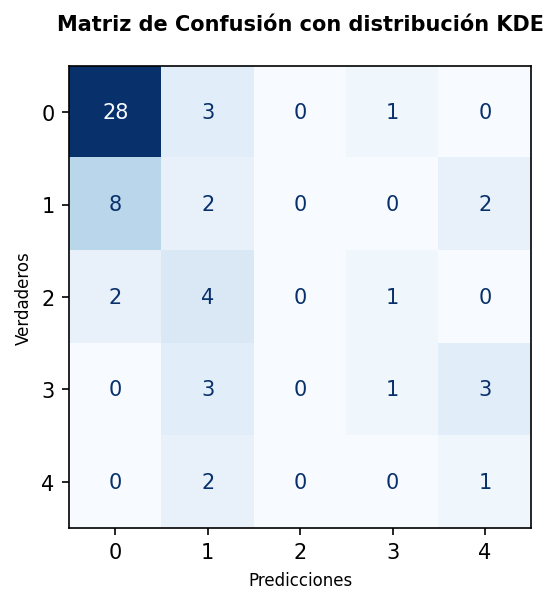

In [22]:
bn.confusion_matrix()

In [23]:
bn.reporte_de_clasificacion()

              precision    recall  f1-score   support

           0       0.74      0.88      0.80        32
           1       0.14      0.17      0.15        12
           2       0.00      0.00      0.00         7
           3       0.33      0.14      0.20         7
           4       0.17      0.33      0.22         3

    accuracy                           0.52        61
   macro avg       0.28      0.30      0.28        61
weighted avg       0.46      0.52      0.48        61



## **Ejemplo Normal**

In [24]:
bn = bayes_naive('Normal')

Se usara la distribucion normal


In [25]:
bn = bayes_naive('normal')

Se usara la distribucion normal


In [26]:
pxjIwi, pwi, Iwi, classes, attributes, newdistributions = bn.fit(predictoras, apredecir, distributions)

Fitting con normal


In [27]:
age = 63
sex = 1
chest_pain_type = 3
resting_blood_pressure = 145
cholesterol = 233
fasting_blood_sugar = 1
resting_ecg = 0
max_heart_rate = 150
exercise_induced_angina = 0
st_depression = 2.3
slope = 1
number_of_major_vessels = 0
thal = 3

In [28]:
bn.predict(age, sex, chest_pain_type, resting_blood_pressure, cholesterol, fasting_blood_sugar, resting_ecg, max_heart_rate, exercise_induced_angina, st_depression, slope, number_of_major_vessels, thal) 

0

In [29]:
testdf = bn.probar_el_clasificador()

Fitting con normal


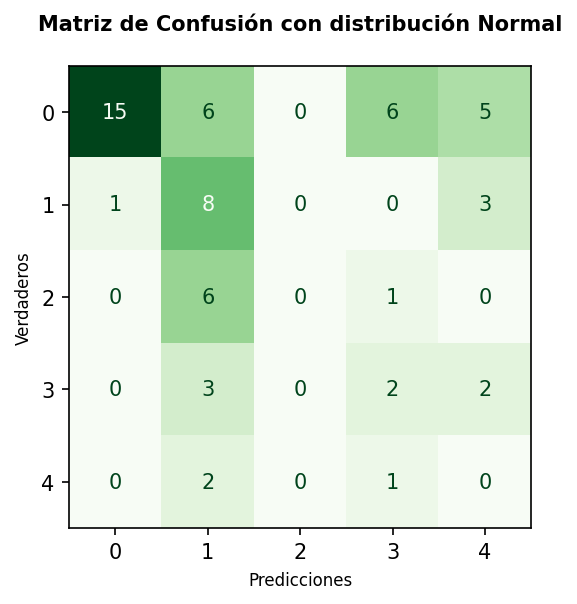

In [30]:
bn.confusion_matrix('Greens')

In [31]:
bn.reporte_de_clasificacion()

              precision    recall  f1-score   support

           0       0.94      0.47      0.62        32
           1       0.32      0.67      0.43        12
           2       0.00      0.00      0.00         7
           3       0.20      0.29      0.24         7
           4       0.00      0.00      0.00         3

    accuracy                           0.41        61
   macro avg       0.29      0.28      0.26        61
weighted avg       0.58      0.41      0.44        61

